#**사람이 말하는 단어를 인공지능 모델로 구분하기**

음성(Speech)은 사람의 언어가 들어있는 소리를 말하는 것이고, 오디오(Audio)는 사람 목소리 이외의 모든 소리를 통칭해서 일컫는 것입니다.

**학습목표** 
- Audio 형태의 데이터를 다루는 방법에 대해서 알아보기
- Wav파일의 형태와 원리를 이해하기
- 오디오 데이터를 다른 다양한 형태로 변형시켜보기
- 차원이 다른 데이터에 사용가능한 classification 모델 직접 제작해보기

**목차**
1. 들어가며
2. 음성데이터란
3. Train/ Test 데이터셋 구성하기
4. Wav classification 모델 구현
5. Skip-Connection 모델을 추가
6. Spectrogram
7. 프로젝트: Spectrogram classification 모델 구현


#음성과 오디오 데이터

**파동으로서의 소리**

소리는 진동으로 인한 공기의 압축, 압축이 얼마나 됬느냐는 파동(Wave).

소리에서 얻을 수 있는 물리량은 **진폭(Amplitude)**와 주파수(Frequency) 그리고 위상(Phase) 의 3요소로 나타낼 수 있습니다.

물리적 음향에서는 Intensity(강도)를 진폭의 세기로 정의하고, Frequency는 떨림의 빠르기 그리고 Tone-Color는 파동의 모양으로 정의합니다.

심리적 음향에서는 Loudness는 소리의 크기를 말하고, Pitch는 음정, 소리의 높낮이 진동수를 의미합니다.

마지막으로 Timbre는 음색, 소리, 감각등을 나타냅니다.



주파수(frequency)에 따라 소리의 높이가 달라진다.

진폭(Amplitude)에 따라 소리의 세기(크기)가 달라진다.

그래프의 모양 자체가 다르면 음정, 음색 등의 소리의 맵시가 달라진다.

**주파수는 무엇일까요?**

위에서 소리는 공기의 압축 현상이라고 했다.

주파수는 the number of compression, 즉 1초동안의 진동 횟수를 의미하며 단위는 Hz를 사용한다.

Hz는 1초에 한번 진동한다는 것을 의미

주기(period)는 파동이 한번 진도하는데 걸리는 시간, 또는 그 길이를 말함, 일반적으로는 sin 함수의 주기는 2π/ω이다. (ω= 주파수)

소리의 높낮이는 음원의 주파수에 의해 결정됨, 주파수가 높으면 높은소리가나고 낮으면 낮은소리가남

**복합파(Complex Wave)란 무엇일까?**

우리가 사용하는 대부분의 소리들은 복합파이다. 

서로 다른 주파수를 가진 수 많은 소리가 뒤섞여 만들어지는 복합파는, 복수의 서로 다른 정현파(sine wave)들의 합으로 이루어진 파형이다. 

수식으로 표현하자면 아래와 같다.

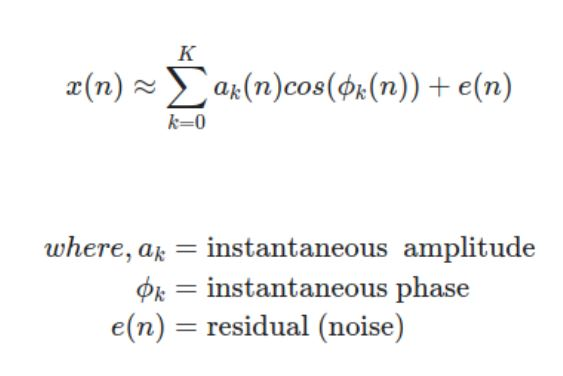



**오디오 데이터의 디지털화**

위에서 언급한 오디오 데이터는 아날로그 데이터로서의 소리에 대한 설명이었다.

그러나 컴퓨터는 0과 1로만 이루어진 디지털 데이터만 취급 가능.

우리가 흔히 볼 수 있는 소리들은 컴퓨터의 입력으로 들어가게 되면 어떤 과정을 거치게 될까?

연속적인 아날로그 신호 중 가장 단순한 형태인 사인 함수(sine function)를 수식으로 표현하면 아래와 같다.

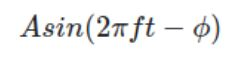

A는 진폭(amplitude)으로 위, 아래로 움직이는 소리의 크기를 나타냄

f는 주파수(frequency)로, 초당 진동 횟수를 나타냄. 즉, 소리의 세기를 나타냄 즉, 주파수가 높으면 빠르게 진동해 소리의 세기가 커짐.

0은 위상이고 t는 시간으로 정의함


**아날로그 신호의 표본화(Sampling)**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequency, sampling_rate = 16000, duration=1):
  t = np.linspace(0, duration, int(sampling_rate))
  y = np.sin(2*np.pi*frequency*t)
  return y

y= single_tone(400)

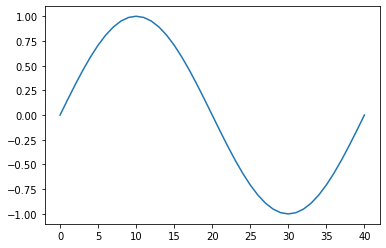

In [2]:
plt.plot(y[:41])
plt.show()

시간축 방향에서 일정 간격으로 샘플을 추출해 이산 신호(discrete signal)로 변환시키는 과정을 표본화(Sampling)라고 부른다.

아래 그래프는 1사이클 동안 나타나는 이산시간 연속크기 신호다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


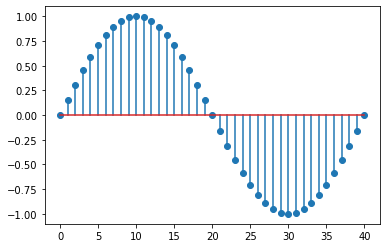

In [3]:
plt.stem(y[:41])
plt.show()

우리는 위에서 single_tone() 함수 구현시 sampling rate를 16000으로 지정하고, duration은 1초, 그리고 주파수는 400인 사인 함수를 정의했다.

여기서 sampling rate 는 무엇일까? 

초당 샘플링의 횟수를 말한다.

샘플링이란? 1초의 연속적인 신호를 몇 개의 숫자로 나눌 것인지를 말한다.

그렇다면 Sampling rate는 어떻게 설정하는 것이 좋을까?

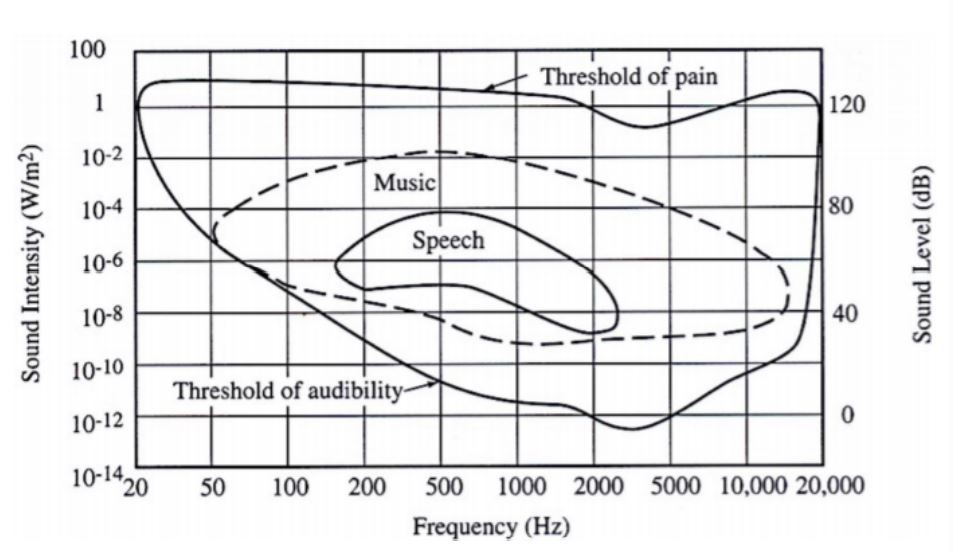

나이키스트- 섀넌 표본화에 따라 Sampling rate가 결정되며, 일반적으로 사용되는 주파수 영역대는 16kHz, 44.1kHz를 많이 사용한다.

16kHz는 보통 Speech에서 많이 사용되는 주파수 영역대이고, 44.1kHz는 Music에서 많이 사용하는 주파수 영역대이다.

우리는 음성 데이터를 사용할 것이므로, sampling rate를 16000(16k)으로 지정한다.

duration은 지속시간을 나타내며, 단위는 초단위이다. 

여기서 Hz는 주기가 일정하게 반복 되는 횟수를 의미하며, 이를 주파수라 칭한다. 따라서 주파수의 단위는 Hz이다.

    Q1. 나이키스트-섀넌 표본화에 따르면 Sampling rate는 어떻게 결정하라고 나와있나요?

    아날로그를 디지털로 거친 후 디지털을 아날로그로 왜곡없이 복원하기 위해서는 표본화 된 최대 주파수가 2배보다 더 클 때 가능하다고 나와있습니다.

    Q2. 오디오(Music)에서는 왜 44.1kHz를 사용 할까요?

    인간의 최대 가청 주파수가 20kHz이기 때문에 나이키스트 섀넌 표본화에 따라 40kHz읜 sampling frequency를 기준으로 잡는다.

    실제로는 추가적인 이유로 오디오 레코드에선 44.1kHz를 사용한다.



**표본화, 양자화, 부호화**

연속적인 아날로그 신호를 컴퓨터 입력으로 넣게 되면 표본화(Sampling), 양자화(Quantizing), 부호화(Encoding)을 거쳐 이진 디지털 신호(Binary Digital Signal)로 변화시켜 인식하게 된다.

아래 그림은 아날로그 오디오 신호를 표본화 양자화 하는 과정을 시각화 하여 보여준다.

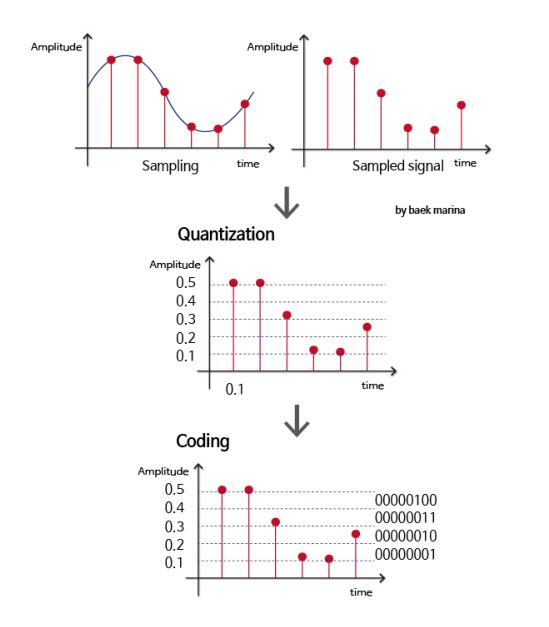

위에서 설명한 바와 같이 아날로그 데이터에서 일정 간격으로 표본을 채취하는 방식으로 이산적 데이터를 구한다.

그러나 디지털화를 위해서는 이산적 데이터의 값 자체가 소수점 아래로 무한히 정밀해질 수 없고, 일정간격으로 값을 근사하여 구할수 밖에 없다.

이 과정을 양자화 라고 한다.

이과정에서 원본 아날로그 데이터화의 차이가 발생하고 미세한 왜곡이 발생한다.

Sampling rate가 클수록 이 기대 왜곡치가 작아져 원본에 가까운 형태로 변환된다.

그리고 마지막으로 부호화를 통해 표본화 -> 양자화를 거친 원본 아날로그 수치가 최종적인 디지털 표현(0과 1로만 이루어진)을 얻게 된다.



**Wave data분석**

이제 오늘 만들어볼 음성인식 모델을 위한 학습데이터를 분석해보자.

아래와 같이 환경을 구성한 후, 데이터 다운로드를 진행해라.

주의:1.6GB의 데이터이다. 다운로드에 시간이 걸리니 주의해라.

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
np.load('/gdrive/My Drive/speech_wav_8000.npz')



**Wave 데이터 형식 뜯어보기**

- Audio 데이터는 이미지 데이터보다 낮은 차원의 데이터를 다룹니다. 1개의 wav 파일은 1차원으로 이루어진 시계열 데이터다. 실제로는 여러 소리 파형이 합쳐진 복합파라고 보아야한다.

**간단한 단어 인식을 위한 훈련 데이터셋**

- 짧은 단어의 라벨이 달려 있어, 음성들을 텍스트로 구분하는 모델 혹은 간단한 명령어를 구별하는 모델로도 학습이 가능하다. 

**Bits per sample**

- 샘플 하나마다 소리의 세기를 몇 비트로 저장했는지를 나타낸다.

- 값이 커질수록 세기를 정확하게 저장할수 있다. 예를들어 Bits rate가 16bits 라면, 소리의 세기를 216, 즉 65,536단계로 표현할 수 있다.

- 4bits/ 8bits unsigned int/ 16bits int/ 24bits/ 32bits float 등의 자료형으로 표현된다. 

**Sampling frequency**

- 샘플링 주파수라는 단어다. 소리로부터 초당 샘플링한 횟수를 의미한다.
- 샘플링은 원래 신호를 다시 복원할 수 있는 나이퀴스트(Nyquist) 샘플링 룰에 따라서, 복원 해야 할 신호 주파수의 2배 이상으로 샘플링 해야한다.

- 가청 주파수 20~24kHz를 복원하기 위해 사용하며, 음원레서 많이 쓰이는 값은 44.1kHz다

**Channel**
- 각 채널별로 샘플링된 데이터가 따로 저장되어있다.
- 2채널(Stereo) 음원을 재생하면 왼쪽(L)과 오른쪽(R) 스피커에 다른 값이 출력된다.
- 1채널(Mono) 음원의 경우 왼쪽(L) 데이터만 있으며, 재생시엔 왼쪽(L)과 오른쪽(R) 스피커에 같은 값이 출력된다.

- 1000 Hz 신호를 저장한 wav파일이다.
- Sample rate 는 48000 Hz, 즉 1초 재생하는데 필요한 Sample수는 48000개이다.
- 모든 샘플은 -1~ 1 사이의 정해진 bits per sample의 값으로 표현된다.

In [5]:
import numpy as np
import os

speech_data = np.load('/gdrive/My Drive/speech_wav_8000.npz')

**데이터셋 살펴보기**

- npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어 있다.

In [29]:
print("Wave data shape: ", speech_data["wav_vals"].shape)
print("Label data shape: ",speech_data["label_vals"].shape)
print("v")

Wave data shape:  (50620, 8000)
Label data shape:  (50620, 1)
v


 - 데이터셋은 1초 길이의 오디오 음성 데이터 50620개로 이뤄져 있다.
 - 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용한다.
 - 모두 1초의 길이를 가지는 오디오 음성데이터여서 각각 8000개의 sample data를 가지고 있다.

**데이터셋은 캐글의 음성 인식 챌린지의 데이터입니다.

Kaggle/TensorFlow Speech Recognition Challenge. This is

version 0.01 of the data set containing 64,727 audio files,

released on August 3rd 2017**


In [30]:
#위에서 설명한 데이터가 맞는지 확인해 보자.

import IPython.display as ipd
import random

#데이터 선택(랜덤하게 선택하고 있으니, 여러번 실행해 보시오.)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 #1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  35170
Wave data shape :  (8000,)
label :  ['right']


#**Train/Test 데이터셋 구성하기**

**Label data 처리**

현재 단어의 정답은 Text 형태로 이뤄져 있습니다. 학습을 위해서는 Text 데이터를 학습 가능한 형태로 만들어 줘야 한다.

아래는 구분해야 할 label목록 이다.
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

이외 데이터들은 'unknown', 'silence' 로 분류되어 있다.


In [31]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL: ',label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
  new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


Text 로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하였다.

int 로 이뤄진 index 작업을 통해서 Label data 를 더 쉽게 사용할 수 있다.

In [32]:
temp = []
for v in speech_data["label_vals"]:
  temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

**학습을 위한 데이터 분리**
sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리하겠습니다.

test_size 의 인자를 조절해 주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있습니다.

In [33]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"],
                                                                label_data,
                                                                test_size=0.1,
                                                                shuffle=True)

print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) #add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1]) 



[[ 5.0126659e-05  1.2297512e-04  9.7447002e-05 ...  2.3240311e-05
   7.6152144e-05  1.3245778e-04]
 [ 3.1429203e-03  4.2060064e-03 -4.1920666e-04 ...  3.1958348e-03
   2.6206907e-03 -1.5413784e-03]
 [-1.1500454e-03 -6.7983934e-04 -6.8726935e-05 ... -4.9699802e-04
  -2.5408745e-03 -3.2450214e-03]
 ...
 [ 3.1270655e-03  4.5566377e-03 -2.1214248e-04 ...  2.5553808e-03
   1.7354896e-03 -2.0716847e-03]
 [ 1.1473054e-02  1.9152004e-02  1.4266840e-02 ... -1.4894917e-02
  -1.3546318e-02 -1.6830152e-02]
 [-8.9241535e-04 -1.7707513e-03 -1.4841945e-03 ... -1.8897119e-03
  -2.4377727e-03 -2.9507079e-03]]


나눠진 데이터셋을 확인해본다

In [34]:
print("train data: ", train_wav.shape)
print("train labels: ", train_label.shape)
print("test data: ", test_wav.shape)
print("test labels: ", test_label.shape)

train data:  (45558, 8000, 1)
train labels:  (45558,)
test data:  (5062, 8000, 1)
test labels:  (5062,)


**Hyper-parameters setting**

학습을 위한 하이퍼파라미터를 설정해 준다.

모델 체크포인트 저장을 위한 체크포인트 경로를 설정한다.

후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용한다.

In [35]:
batch_size = 32
max_epochs = 10

#the save point
checkpoint_dir = os.getenv('HOME')+'/EIP/Exploratory_5/speech_recognition/models/wav'

checkpoint_dir


'/root/EIP/Exploratory_5/speech_recognition/models/wav'

**Data setting** 

tf.data.Dataset 을 이용해서 데이터셋을 구성한다.

Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해준다. 

자주 사용하게 되니 사용법을 잘 익혀둬라.

tf.data.Dataset.from._tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있다.

map 함수는 dataset이 데이터를 불러올때 마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 한다.

첫번째 map함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다. 

map함수는 중첩해서 사용이 가능하다.

map 함수에 넘겨줄 데이터 전처리 함수를 작성해보자.

In [36]:
def one_hot_label(wav, label):
  label = tf.one_hot(label, depth=12)
  return wav, label

tf.data.Dataset 함수를 구성한다.

batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수다.



In [37]:
import tensorflow as tf

#for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size = batch_size)
print(train_dataset)

#for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size = batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


#**Wave classification 모델 구현**

**Model**

Audio 데이터 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성해줘야 한다.

Conv1D layer 를 이용해 모델을 구성해본다.

Conv, batch norm, dropout, dese layer 등을 이용해 모델을 구성해 본다.

In [38]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

**Loss**

현재 라벨이 될 수 있는 12개의 단어 class를 가지고 있다.
해당 class를 구분하기 위해서는 multi-class classification이 필요하며, 이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용하겠다.


In [39]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])


**Training**
**Callback**

- model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간중간 원하는 동작을 하도록 설정할 수 있다.
- 모델을 재사용 하기위서 모델 가중치를 저장하는 callback 함수를 추가해본다.

Model Checkpoint callback 은 모델 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터 하며 동작하게 설정할수 있다.

현재 모델은 validation loss를 모니터하며, loss가 낮아지면ㄴ 모델 파라미터를 저장하도록 구성 되어 있다.

In [40]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only = True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

아래는 모델 학습 코드이다.

이전 스텝의 하이퍼 파라미터 세팅에서 batch_size=32, max_epochs=10으로 세팅한 경우라면 30분 가량 소모될 것이다.

메모리 사용량에 주의하며 적절히 하이퍼파라미터 세팅을 조절해라.

메모리가 부족하다면 batch_size를 작게 조절해 주는게 좋다


In [41]:
#30분 내외 소요(메모리 사용량에 주의해라.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                            steps_per_epoch=len(train_wav) // batch_size,
                            validation_data = test_dataset, 
                            validation_steps=len(test_wav)// batch_size,
                            callbacks=[cp_callback]
)

Epoch 1/10
1423/1423 [==============================] - 225s 135ms/step - loss: 1.7319 - accuracy: 0.4103 - val_loss: 0.9098 - val_accuracy: 0.7097

Epoch 00001: val_loss improved from inf to 0.90977, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav
Epoch 2/10
1423/1423 [==============================] - 191s 134ms/step - loss: 0.8446 - accuracy: 0.7403 - val_loss: 0.6372 - val_accuracy: 0.7959

Epoch 00002: val_loss improved from 0.90977 to 0.63716, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav
Epoch 3/10
1423/1423 [==============================] - 191s 134ms/step - loss: 0.5783 - accuracy: 0.8255 - val_loss: 0.4512 - val_accuracy: 0.8616

Epoch 00003: val_loss improved from 0.63716 to 0.45120, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav
Epoch 4/10
1423/1423 [==============================] - 192s 135ms/step - loss: 0.3943 - accuracy: 0.8848 - val_loss: 0.3672 - val_accuracy: 0.8853

Epoch 00004: val_loss improved

**학습결과 Plot**

model.fit 함수는 학습 동안의 결과를 return해줍니다.

return 값을 기반으로 loss와 accuracy 를 그래프로 표현하겠습니다.

fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있습니다.

train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있습니다.

출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인해볼 수 있습니다.

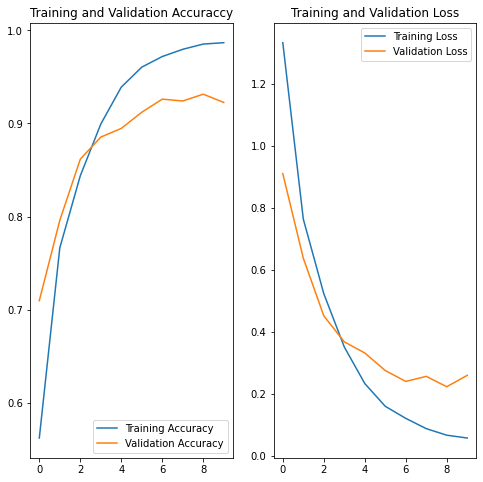

In [64]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss = history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuraccy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Evaluation**

test dataset을 이용해서 모델의 성능을 평가한다.

실습삼아 checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비를 해보자.

In [65]:
model_wav.load_weights(checkpoint_dir)



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f7690294dd0> and <tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f7690393910>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f7690393910> and <tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7f769029cd90>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f769022d990> and <tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7f7690224490>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f7690224410> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f7690240c10>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f76902

ValueError: ignored

Test data 를 이용해 모델의 예측값과 실제값이 얼마나 일치하는지 확인한다.

In [66]:
results = model_wav.evaluate(test_dataset)


159/159 [==============================] - 6s 38ms/step - loss: 0.2224 - accuracy: 0.9313


In [67]:
#loss
print("loss value : {:.3f}".format(results[0]))

#accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value : 0.222
accuracy value: 93.1252%


**Model Test**

Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해본다.

In [68]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label: ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label:  up


위에서 확인해본 테스트 셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.

In [69]:
if np.argmax(y_pred_) == batch_ys[0]:
  print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) +'(correct!)')
else:
  print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) +'(Incorrect!)')


y_pred: up(correct!)


#**Skip-Connection model 을 추가해보자**

**Skip-Connection model 구현**
이전 스텝에서 우리는 Conv1D 기반의 간단한 분류 모델을 구현해서 학습 및 테스트를 진행해 보았다.

간단한 모델임에도 정확도가 나쁘지 않았을 것이다.

하지만 여러분들은 이미지 처리 모델을 다루면서 ResNet 등 skip-connection을 활용한 모델들이 훨씬 안정적으로 높은 성능을 낼 수 있음을 배워왔을 것이다.

그렇다면 이번 음성처리 모델에 적용해도 비슷한 개선 효과를 낼수 있지않을까?

기존의 모델을 skip-connection이 추가된 모델로 변경해 학습을 진행해보자.

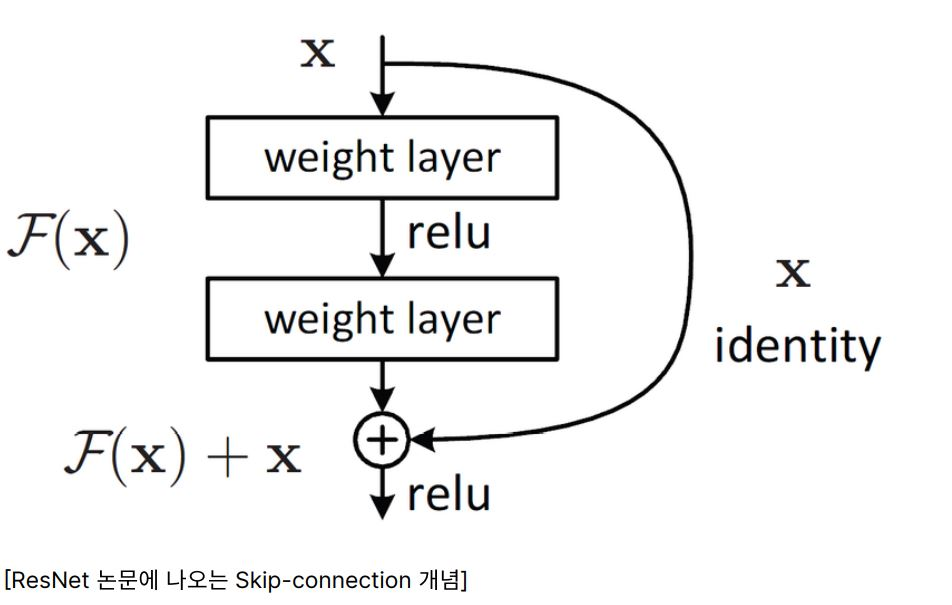

그림에서 보듯이 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨을 확인할 수 있다.

Concat을 이용한 방식으로 구현하면 된다.

tf.concat([#layer output tensor, layer output tensor#], axis=#)

우리가 사용하는 데이터가 1차원 audio 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성해 보겠다.


In [70]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 8000, 32)     320         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 8000, 32)     9248        conv1d_29[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 4000, 32)     0           conv1d_30[0][0]                  
____________________________________________________________________________________________

모델 구성만 달라졌을 뿐 그 외 Task 구성이나 데이터셋 구성, 훈련 과정은 동일하다.

In [71]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       optimizer=optimizer,
                       metrics=['accuracy'])


In [72]:
#the save point
checkpoint_dir = os.getenv('HOME')+'/EIP/Exploratory_5/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [60]:
#30분 내외 소요
history_wavskip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                                     steps_per_epoch=len(train_wav)//batch_size,
                                     validation_data=test_dataset,
                                     validation_steps=len(test_wav)//batch_size,
                                     callbacks=[cp_callback])

Epoch 1/10
1423/1423 [==============================] - 253s 176ms/step - loss: 1.6082 - accuracy: 0.4654 - val_loss: 0.9664 - val_accuracy: 0.6816

Epoch 00001: val_loss improved from inf to 0.96642, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav_skip
Epoch 2/10
1423/1423 [==============================] - 253s 178ms/step - loss: 0.7268 - accuracy: 0.7825 - val_loss: 0.5105 - val_accuracy: 0.8400

Epoch 00002: val_loss improved from 0.96642 to 0.51047, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav_skip
Epoch 3/10
1423/1423 [==============================] - 249s 175ms/step - loss: 0.4215 - accuracy: 0.8852 - val_loss: 0.4414 - val_accuracy: 0.8625

Epoch 00003: val_loss improved from 0.51047 to 0.44141, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav_skip
Epoch 4/10
1423/1423 [==============================] - 249s 175ms/step - loss: 0.2276 - accuracy: 0.9458 - val_loss: 0.2674 - val_accuracy: 0.9193

Epoch 00004: va

학습 결과의 시각화 및 evaluation 과정도 동일합니다.

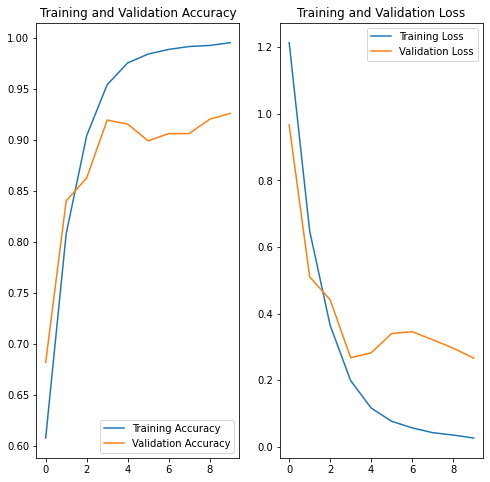

In [74]:
import matplotlib.pyplot as plt

acc = history_wavskip.history['accuracy']
val_acc = history_wavskip.history['val_accuracy']

loss=history_wavskip.history['loss']
val_loss=history_wavskip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
#Evaluation

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

#loss
print("loss value: {:.3f}".format(results[0]))

#accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 8s 49ms/step - loss: 0.2715 - accuracy: 0.9229
loss value: 0.267
accuracy value: 92.5721%


In [78]:
#Test

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  silence


위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction결과를 비교

In [79]:
if np.argmax(y_pred_) == batch_ys[0]:
  print("y_pred: "+ str(inv_label_value[np.argmax(y_pred_)]) +'(Correct!)')
else:
  print("y_pred : "+ str(inv_label_value[np.argmax(y_pred_)])+'(Incorrect!)')
  

y_pred : up(Incorrect!)


#**Spectrogram**

우리는 지금까지 음성 데이터를 1차원 시계열 데이터로 해석하는 waveform 해석을 통해 다루어 왔다.

그러나 우리가 다루는 waveform은 실은 많은 음원의 파형이 합성된 복합파라는 것을 앞서 언급했다. 그렇다면 보다 뚜렷이 다양한 파형들을 그 주파수 대역별로 나누어 별도로 해석해 볼 수 있는 방법은 없을까?

이제 우리가 자주 들었던 푸리에 변환(Fourier transform)을 언급할 때가 된 것 같다.

**푸리에변환(Fourier transform)**

임의의 입력 신호를 다양한 주파수를 갖는 주기함수 (복수 지수함수)들이 합으로 분해하여 표현하는 것을 말한다.

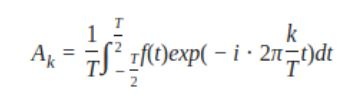

그러나 보다 직관적인 이해는 아래그림을 참고하는것이 좋겠다. 위 수식과 아래 그림의 의미는 같다.

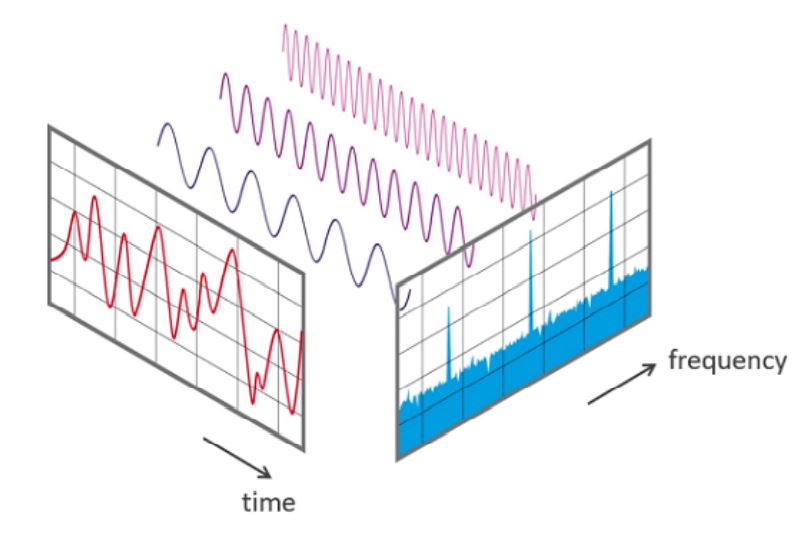


**조금 더 깊이 들어가는 푸리에 변환**

**오일러 공식(지수함수와 주기함수와의 관계)**

여기서 cos2πkT, jsin2πkT함수는 주기와 주파수를 가지는 주기함수 이다.

즉 푸리에 변환은 입력 signal이 어떤것인지 상관 없이 sin, cos과 같은 주기함수들의 합으로 항상 분해가 가능하다.
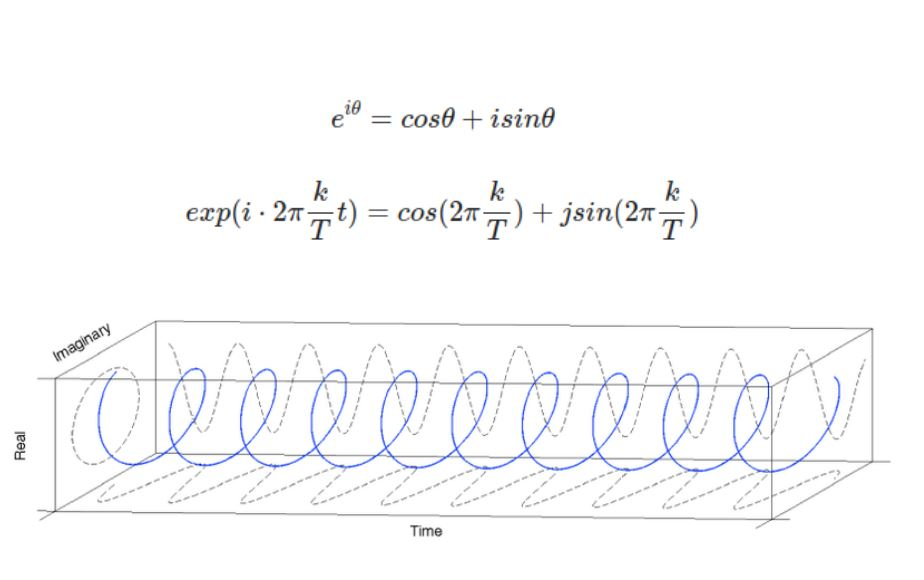

푸리에 변환이 끝나면, 이제 실수부와 허수부를 가지는 복소수가 얻어진다.

이러한 복소수의 절대값은 Spectrum magnitude(주파수의 강도)라고 부르며, 복소수가 가지는 phase는 phase spectrum(주파수의 위상)이라 부르게 된다.

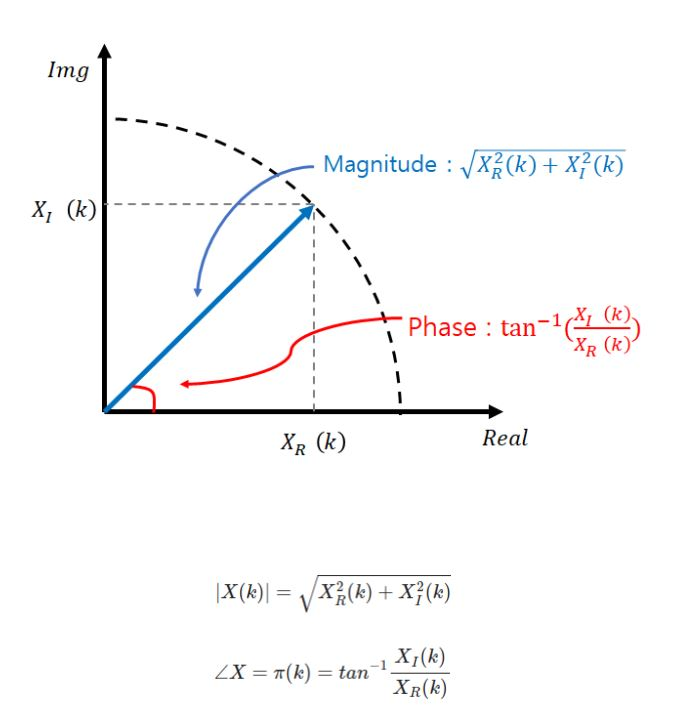



**STFT(Short Time Fourier Transform)**

FFT는 시간에 흐름에 따라 신호의 주파수가 변했을 때, 어느 시간대에 주파수가 변하는지 모르게 된다.

이러한 한계를 극복하기 위해서, STFT는 시간의 길이를 나눠서 푸리에 변환을 하게된다.

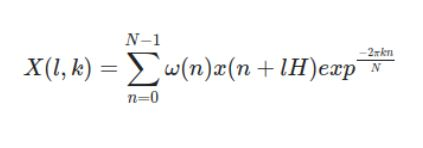

- N 은 FFT size 이고, Window를 얼마나 많은 주파수 밴드로 나누는가를 의미한다.
- Duration은 sampling rate 를 window 로 나눈 값입니다. T=window/sampling rate.

duration 은 신호주기보다 5배이상 길게 잡아야 합니다. T(window)=5T(Signal)

예를 들어 440Hz신호의 window size는 5 (1/440)이 됩니다.

- ω(n)는 window함수를 나타냅니다. 일반적으로는 hann window가 많이 쓰입니다.
- n은 window size 입니다. window 함수에 들어가는 sample의 양입니다. n이 작을수록 low-frequency resolution을 가지게 되고, high-time resolution을 가지게 되고, n이 길수록 high-frequency를 가지게 되고 low-time resolution을 가지게 됩니다. 
- H는 hot size를 의미합니다. 윈도우가 겹쳐지는 사이즈 입니다. 일반적으로는 1/4정도를 겹치게 합니다.

**STFT의 결과는 즉 시간 흐름에 따른 frequency영역별 Amplitue 를 반환합니다.**

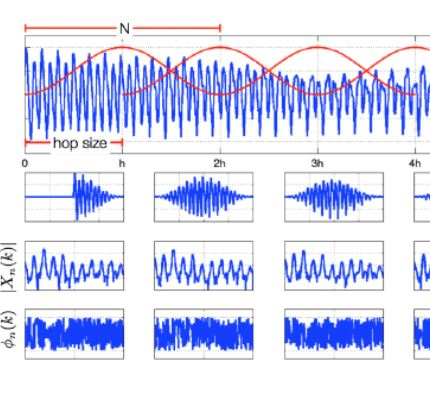


**Spectrogram 이란?**
wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는지를 보여줍니다.
이 Spectrogram 을 그리는 방법이 바로 위에 소개한 STFT입니다

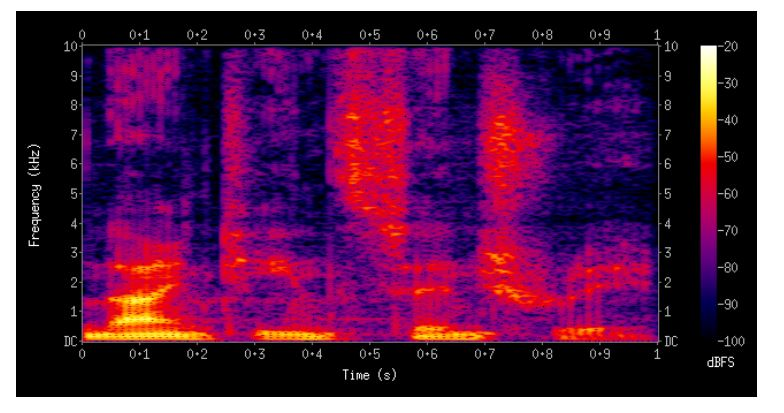

X축은 시간, Y추은 주파수를 나타내며, 해당시간/주파수에서의 음파 강도에 따라 밝은 색으로 표현 됩니다.

wav 데이터가 단위 시간만큼 Short Time Fouier Transform을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram 을 완성합니다.

Step2에서 사용한 샘플데이터를 이용하여 스펙트로그램을 생성해 봅시다.

먼저 파이썬에서 제공하는 FFT관련 라이브러리인 librosa를 설치 합니다.

In [ ]:
pip install librosa

In [88]:
import librosa

def wav2spec(wav, fft_size=258): #spectrogram shape 을 맞추기 위해서 size 변형
  D = np.abs(librosa.stft(wav, n_fft = fft_size))
  return D

In [89]:
data

array([ 0.00934205,  0.01612144,  0.00766477, ..., -0.00629932,
       -0.00749854, -0.0040917 ], dtype=float32)

In [90]:
#위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape: ",data.shape)
print("Spectogram shape: ", spec.shape)

Waveform shape:  (8000,)
Spectogram shape:  (130, 126)


어떤가? 1차원의 Waveform 데이터가 2차원의 Spectrogram데이터로 변환도었다.

그렇다면 방금 변환된 Spectrogram을 출력해 보겠다.

만약에 우리가 Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성 인식 모델을 학습시킨다면, 

과연 Waveform과 비교 했을 때 더 나은 성능을 기대 할수 있을까? 


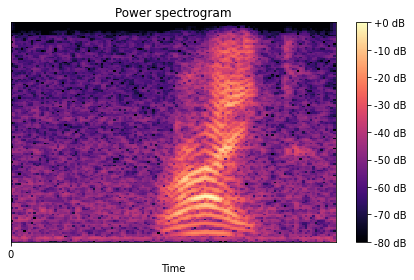

In [91]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0,1))
plt.tight_layout()
plt.show()

#**프로젝트 Spectrogram classification 모델 구현**

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았다.

이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보길 바란다.

이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보길 바란다.

모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일한게 진행될것이다.

**1. 데이터 처리와 분류**
- 라벨 데이터 처리하기
- sklearn의 train_test_split 함수를 이용하여 train,test 분리

In [6]:
import numpy as np
import os

#구글 드라이브에 있는 데이터를 마운트후 np.load로 불러와 speech_data에 저장
speech_data= np.load('/gdrive/My Drive/speech_wav_8000.npz')

In [7]:
#데이터셋 살펴보기
#npz 파일로 이뤄진 데이터, 각각 데이터는 wav_vals, label_vals로 저장 되어있다.

print("Wave data shape: ", speech_data["wav_vals"].shape)
print("Label data shape: ", speech_data["label_vals"].shape)

#데이터셋은 1초 길이의 오디오 음성 데이터 50620개로 이뤄져 있다.
#주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용한다.
#모두 1초 길이를 가지는 오디오 음성 데이터여서 각각 8000개의 sample data를 가진다.

Wave data shape:  (50620, 8000)
Label data shape:  (50620, 1)


In [8]:
#위에서 설명한 데이터가 맞는지 확인
import IPython.display as ipd
import random


In [9]:

#데이터 선택(랜덤하게 선택하고 있으니, 여러번 실행해 보라.)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num: ", rand)


rand num:  42387


In [10]:

sr = 8000   #1초동안 재생되는 샘플의 갯수
#speech_data에 wav_vals의 rand번째 인덱스의 값을 data에 저장
data = speech_data["wav_vals"][rand]

#데이터의 쉐입을 프린트해본다
print("Wave data shape: ", data.shape)

#라벨을 출력해본다.
print("label: ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

Wave data shape:  (8000,)
label:  ['yes']


In [11]:
#데이터를 확인해 봤다.
data

array([ 3.2825875e-03,  4.7066286e-03,  4.5716108e-05, ...,
        2.5736412e-03,  2.0505984e-03, -1.8891043e-03], dtype=float32)

In [12]:
#라벨 데이터 처리
#현재 단어의 정답은 Text 형태로 이뤄져 있다.
#학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어 줘야 한다.
#구분해야할 label 목록은 ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]

#구분해야할 label 목록을 target_list로 저장
target_list=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]

#target_list를 label_value에 저장
label_value = target_list
#lavbel_value에 'unknown' 추가
label_value.append('unknown')
#'slience 추가
label_value.append('silence')

#완성된 label_value를 출력
print('LABEL : ', label_value)

#new_label_value를 딕셔너리로 생성
new_label_value = dict()

#enumerate() 함수는 기본적으로 인덱스와 원소로 이루어진 터플(tuple)만듦.
#만들어둔 label_value를 하나씩 가져와 i, l에 담음.
for i, l in enumerate(label_value):
  #new_label_value에 원소번째 인덱스의 값을 인덱스로 넣어줌
  new_label_value[l]=i
#이렇게 만들어진 new_label_value를 label_value에 넣어줌
label_value = new_label_value
#출력
print('Indexed LABEL : ', new_label_value)
#아래와 같은 형태로 출력됨을 볼수 잇다.

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']

Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}

In [13]:
speech_data['label_vals']

array([['down'],
       ['down'],
       ['down'],
       ...,
       ['silence'],
       ['silence'],
       ['silence']], dtype='<U7')

In [14]:
speech_data['label_vals'][0]

array(['down'], dtype='<U7')

In [15]:
label_value

{'down': 3,
 'go': 9,
 'left': 4,
 'no': 1,
 'off': 7,
 'on': 6,
 'right': 5,
 'silence': 11,
 'stop': 8,
 'unknown': 10,
 'up': 2,
 'yes': 0}

In [16]:
label_value['down']

3

In [17]:
label_value[['down'][0]]

3

In [18]:
#Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index형태로 바꿔주었다.
#int로 이뤄진 index 작업을 통해 Label data를 더 쉽게 사용할 수 있다.

#빈 리스트 temp 생성
temp=[]
#speech_data에 label_vals에 접근 하나씩 가져온다.
for v in speech_data["label_vals"]:
  #label_value 에 접근해 speech_data['label_vals']의 값으로 나온 v의 0번인덱스에 접근.
  #빈 리스트 temp에 추가해준다.
    temp.append(label_value[v[0]])
#이 템프를 넘파이 array로 바꾼뒤 라벨데이터에 넣어준다.
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [19]:
#학습을 위한 데이터 분리
#sklearn의 train_test_split 함수를 이용해 train data와 test data 를 분리.
#test_size 의 인자를 조절해주면, 설정해 준 값 만큼 Test dataset의 비율을 조정 가능

from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"],
                                                                 label_data,
                                                                 test_size=0.1,
                                                                 shuffle=True)
print(train_wav)

#train_wav = train_wav.reshape([-1, sr, 1]) #add channel for CNN
#test_wav = test_wav.reshape([-1, sr, 1])

[[ 1.1072218e-05  7.2158377e-06  2.0272901e-05 ... -3.9092520e-06
   6.5037088e-06 -3.4773486e-05]
 [ 1.6695198e-05  3.3058048e-05 -4.7043181e-05 ... -2.7255400e-04
   4.0794138e-04 -3.1476578e-05]
 [-5.4226208e-02  1.6626543e-01  3.5990515e-01 ... -3.4939253e-01
   2.6216334e-02  2.0934777e-01]
 ...
 [ 8.4951706e-03  1.2605143e-02  7.7126222e-03 ...  2.4595276e-02
   2.2198144e-02  1.3308825e-02]
 [ 4.6237433e-01  3.9567927e-01  4.5545033e-01 ...  8.9020848e-02
  -8.3627701e-02  2.1241272e-02]
 [ 4.4290183e-04  5.5805763e-04  4.4307837e-04 ...  7.4151793e-04
   7.3901779e-04  9.6326263e-04]]


In [20]:
#나눠진 데이터셋을 확인

print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test dat : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000)
train labels :  (45558,)
test dat :  (5062, 8000)
test labels :  (5062,)


#**2. 학습을 위한 하이퍼파라미터 설정**

In [21]:
#모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해준다.
#후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용

batch_size = 32
max_epochs = 10

#the save point
checkpoint_dir = os.getenv('HOME')+'/EIP/Exploratory_5/speech_recognition/models/wav'

checkpoint_dir

'/root/EIP/Exploratory_5/speech_recognition/models/wav'

In [22]:
#tf.data.Dataset 을 이용해서 데이터셋을 구성.
#tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플(date,label) 형태로 넣어서 사용가능
#map 함수는 dataset이 데이털를 불러올 때마다 동작 시킬 데이터 전처리 함수를 매핑해 주는 역할
#첫번째 map 함수는 from_tensor_slice에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정
#map 함수는 중첩해서 사용가능

def one_hot_label(wav, label):
  label = tf.one_hot(label, depth =12)
  return wav, label

#**3. 데이터셋 구성**

- tf.data.Dataset을 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label)형태로 넣어서 사용

- map과 batch를 이용한 데이터 전처리

- 주의: waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있다.

- tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워주면 도움이 된다.

In [23]:
#tf.data.Dataset 함수를 구성한다.
#batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수다.

import tensorflow as tf

#for train

train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

#for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000), (None, 12)), types: (tf.float32, tf.float32)>


#**4. 2차원 Spectrogram 데이터를 처리하는 모델 구성**

- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능

- batchnorm, dropout, dense layer 등을 이용

- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용

- 모델 가중치를 저장하는 checkpoin callback 함수 추가

- 다양한 모델의 실험을 진행해 보아라.

In [24]:
#wav 데이터를 해석하는 방법 중 하나로
#wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는 지를 보여줌.
#이 Spectrogram을 그리는 방법이 바로 위에 소개한 STFT
#x축은 시간, y축은 주파수를 나타내며, 해당시간/ 주파수에서의 음파 강도에 따라 밝은색으로 표현됨
#wav 데이터가 단위 시간만큼 Short Time Fourier Transform을 진행해 매 순간의 주파수 데이터를 얻어서 Spectrogram을 완성


In [25]:
import librosa

def wav2spec(wav, fft_size=258): #spectrogram shape을 맞추기 위해서 size변형
  D = np.abs(librosa.stft(wav, n_fft=fft_size))
  return D

In [26]:
#위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


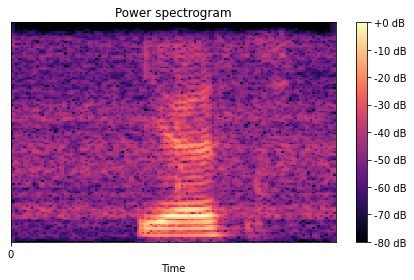

In [27]:
#변환된 Spectrogam 을 출력

import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [28]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr,1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [29]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [30]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [31]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                            steps_per_epoch=len(train_wav) // batch_size,
                            validation_data=test_dataset,
                            validation_steps=len(test_wav) // batch_size,
                            callbacks=[cp_callback])

Epoch 1/10
1423/1423 [==============================] - 485s 319ms/step - loss: 1.8289 - accuracy: 0.3718 - val_loss: 1.0083 - val_accuracy: 0.6760

Epoch 00001: val_loss improved from inf to 1.00829, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav
Epoch 2/10
1423/1423 [==============================] - 454s 319ms/step - loss: 0.9001 - accuracy: 0.7192 - val_loss: 0.7688 - val_accuracy: 0.7474

Epoch 00002: val_loss improved from 1.00829 to 0.76879, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav
Epoch 3/10
1423/1423 [==============================] - 454s 319ms/step - loss: 0.6064 - accuracy: 0.8138 - val_loss: 0.5338 - val_accuracy: 0.8317

Epoch 00003: val_loss improved from 0.76879 to 0.53379, saving model to /root/EIP/Exploratory_5/speech_recognition/models/wav
Epoch 4/10
1423/1423 [==============================] - 453s 319ms/step - loss: 0.4257 - accuracy: 0.8744 - val_loss: 0.4209 - val_accuracy: 0.8714

Epoch 00004: val_loss improved

#**5.학습 후, 학습이 어떻게 진행 됐는지 그래프로 출력**

- loss, accuracy를 그래프로 표현

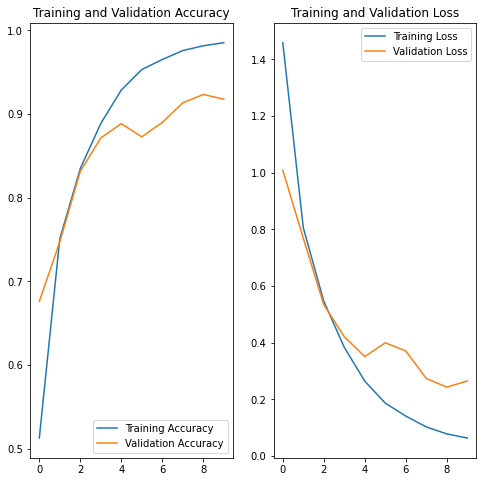

In [32]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#**6. Test dataset을 이용해서 모델의 성능을 평가**

In [33]:
model_wav.load_weights(checkpoint_dir)

In [34]:
results = model_wav.evaluate(test_dataset)

159/159 [==============================] - 15s 90ms/step - loss: 0.2427 - accuracy: 0.9235


In [35]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.243
accuracy value: 92.3548%


In [36]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  up


In [37]:
if np.argmax(y_pred_) == batch_ys[0]:
  print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
  print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: off(Incorrect!)
